# Image background subtraction - Testfile

This file explores the method of background subtraction of plant leaf images captured from mobile camera. Background subtracted images will then be treated as input images to the plant leaf identification system.


### Importing necessary libraries


In [1]:
import os
import cv2
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

%matplotlib inline

from cv2.typing import MatLike
from collections.abc import Sequence

### Reading the image

###### Note: 'mobile captures' folder must be in the project root


In [3]:
from modules.dataset import DATASET_TRAIN_DIR

IMAGE = next(f for f in DATASET_TRAIN_DIR.rglob("*") if not f.is_dir())

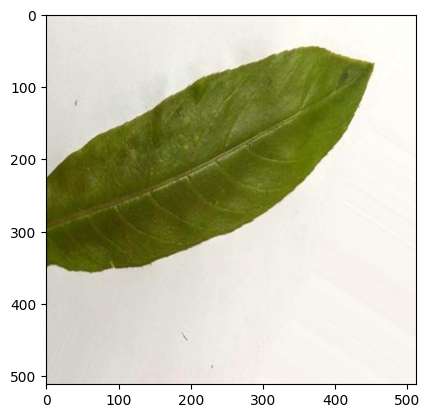

In [4]:
main_img = cv2.imread(str(IMAGE))
img = cv2.cvtColor(main_img, cv2.COLOR_BGR2RGB)
plt.imshow(img, cmap="Greys_r")

### Resizing the image to (1600,1200) - Optional

This is done as all the images in the flavia dataset were of size (1600,1200)


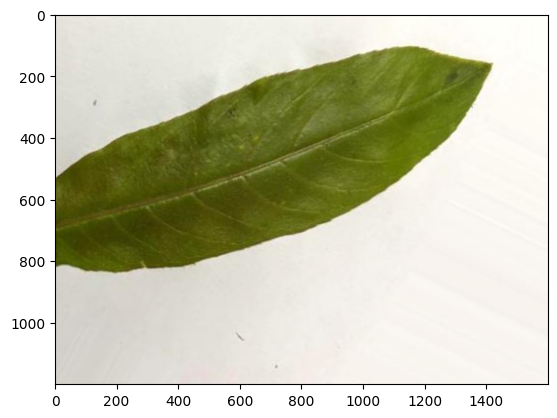

In [5]:
resized_image = cv2.resize(img, (1600, 1200))
plt.imshow(resized_image, cmap="Greys_r")

In [6]:
y, x, _ = img.shape

### Converting image to grayscale


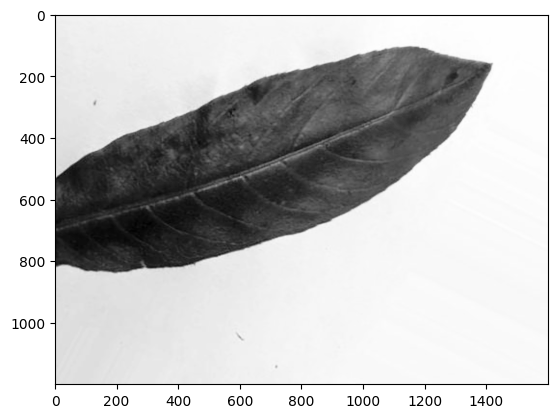

In [7]:
gs = cv2.cvtColor(resized_image, cv2.COLOR_RGB2GRAY)
plt.imshow(gs, cmap="Greys_r")

### Smoothing image using Guassian filter of size (55,55)


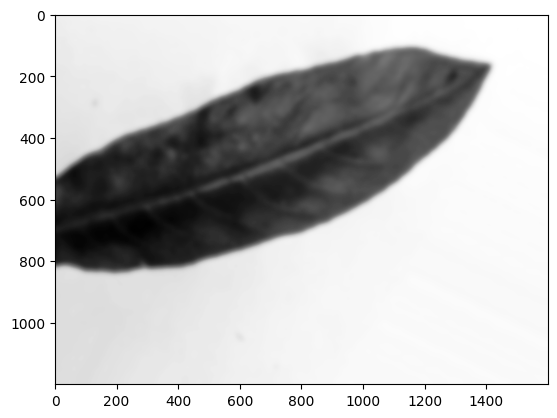

In [8]:
blur = cv2.GaussianBlur(gs, (55, 55), 0)
plt.imshow(blur, cmap="Greys_r")

### Adaptive image thresholding using Otsu's thresholding method


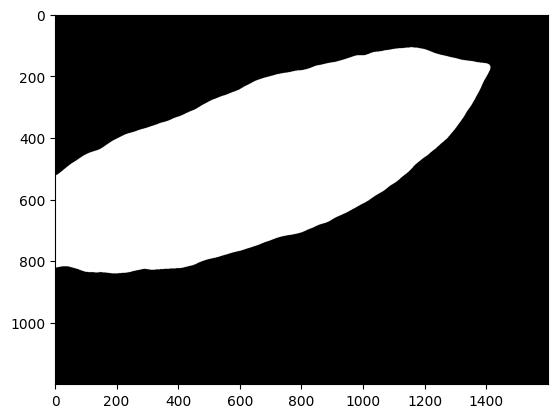

In [9]:
ret_otsu, im_bw_otsu = cv2.threshold(
    blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU
)
plt.imshow(im_bw_otsu, cmap="Greys_r")

### Closing of holes using Morphological Transformation

Performed so as to close any holes present in the leaf


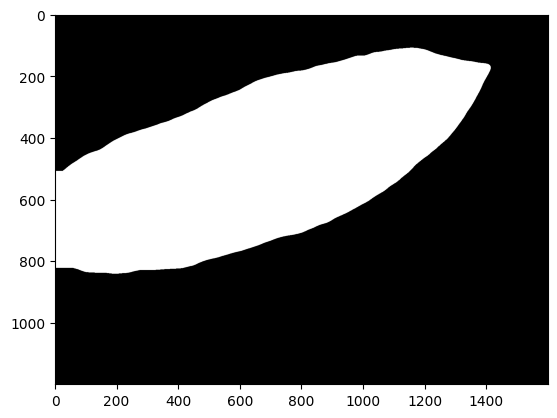

In [10]:
kernel = np.ones((50, 50), np.uint8)
closing = cv2.morphologyEx(im_bw_otsu, cv2.MORPH_CLOSE, kernel)
plt.imshow(closing, cmap="Greys_r")

### Finding contours


In [12]:
contours, _ = cv2.findContours(closing, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

In [13]:
len(contours)

1

### Finding the correct leaf contour from the list of contours

The following function finds the correct leaf contour by taking any coordinate point of the leaf (default - center point) and checks whether the current contour contains that point or not. Returns the index of the correct contour.


In [14]:
def find_contour(contours: Sequence[MatLike]):
    y_ri, x_ri, _ = resized_image.shape
    contains = [
        cv2.pointPolygonTest(c, (x_ri // 2, y_ri // 2), False) for c in contours
    ]

    val = [contains.index(temp) for temp in contains if temp > 0]
    print(contains)
    return val[0]

### Creating mask image for background subtraction using leaf contour


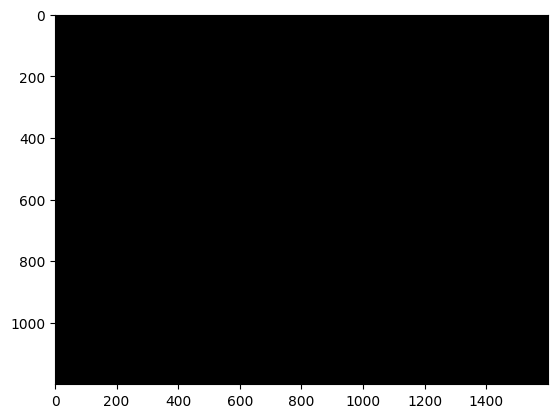

In [15]:
black_img = np.empty([1200, 1600, 3], dtype=np.uint8)
black_img.fill(0)
plt.imshow(black_img, cmap="Greys_r")

[1.0]


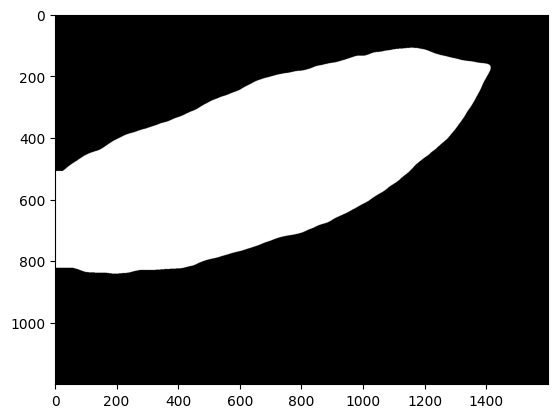

In [16]:
index = find_contour(contours)
cnt = contours[index]
mask = cv2.drawContours(black_img, [cnt], 0, (255, 255, 255), -1)
plt.imshow(mask)

### Performing masking operation on the original image


In [17]:
maskedImg = cv2.bitwise_and(resized_image, mask)

In [18]:
white_pix = [255, 255, 255]
black_pix = [0, 0, 0]

final_img = maskedImg
h, w, channels = final_img.shape
for x in range(0, w):
    for y in range(0, h):
        channels_xy = final_img[y, x]
        if all(channels_xy == black_pix):
            final_img[y, x] = white_pix

### Background subtracted image


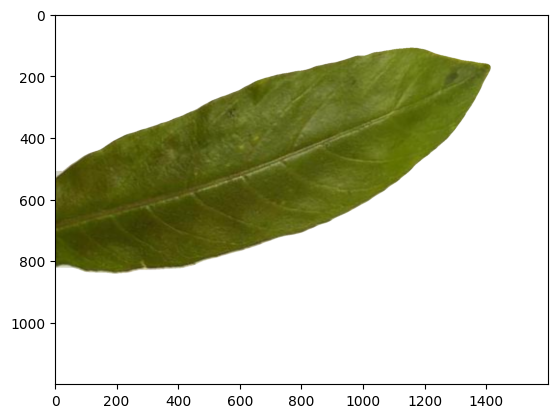

In [19]:
plt.imshow(final_img)